# Louisiana - Data Management

## Import the Necessary Packages

In [1]:
# For working with graphs
import networkx as nx
# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup
maup.progress.enabled = True

## Load the Initial Plan

In [2]:
la_init_gdf = gpd.read_file("HB1_Congress_221ES/HB1_Congress_221ES.shp")

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
la_init_gdf

,ID,AREA,OBJECTID,DISTRICT_I,NAME,NUM_MEMBER,IDEAL_POP,IS_LOCKED,SHAPE_AREA,SHAPE_LEN,geometry
0,5,15208.31440,5,5,District 5,1,776292,0,3.746101,19.820423,"POLYGON ((-92.06893 33.00799, -92.06840 33.007..."
1,3,8612.33105,3,3,District 3,1,776292,0,2.082512,9.691517,"POLYGON ((-91.75621 30.49813, -91.75580 30.498..."
2,4,13676.68750,4,4,District 4,1,776292,0,3.369344,16.654527,"POLYGON ((-92.06893 33.00799, -92.06894 33.007..."
3,1,9001.86621,1,1,District 1,1,776292,0,2.170494,13.215370,"POLYGON ((-90.54688 30.43161, -90.54679 30.431..."
4,6,4452.85351,6,6,District 6,1,776292,1,1.077026,13.590078,"POLYGON ((-91.70134 30.49775, -91.67922 30.497..."
5,2,1472.28369,2,2,District 2,1,776292,0,0.356254,8.820947,"POLYGON ((-90.27949 30.00680, -90.27923 30.006..."


## Load the Second Plan

In [3]:
# Read shapefile data into a geo data frame
la_adopt_gdf = gpd.read_file("Act_2_1st_ES_(2024)_-_Congress/Act_2_1st_ES_(2024)_-_Congress.shp")
la_adopt_gdf

,OBJECTID,DISTRICT_I,NAME,NUM_MEMBER,IDEAL_POP,IS_LOCKED,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,District 1,1,776292,0,2.052146,13.040607,"POLYGON ((-90.25170 30.71172, -90.24707 30.710..."
1,2,2,District 2,1,776292,1,0.578006,8.192319,"POLYGON ((-91.67661 30.49756, -91.67506 30.497..."
2,3,3,District 3,1,776292,0,2.568008,13.348879,"POLYGON ((-91.65466 30.45434, -91.64773 30.449..."
3,4,4,District 4,1,776292,0,3.712209,24.135723,"POLYGON ((-93.90428 33.01957, -93.90115 33.019..."
4,5,5,District 5,1,776292,0,2.657801,20.480358,"POLYGON ((-92.04496 33.00775, -92.03708 33.007..."
5,6,6,District 6,1,776292,0,1.233560,17.409487,"POLYGON ((-93.83448 32.60151, -93.83287 32.600..."


## Add the Congressional Districting Plans to the Precinct Voting Data

In [4]:
# Import 2022 General Election voting data
la_data_gdf = gpd.read_file('la_gen_2022_prec/la_gen_2022_prec.shp')
la_data_gdf.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'Parish', 'Precinct', 'CONG_DIST', 'SLDU_DIST',
       'G22A1NO', 'G22A1YES', 'G22A2NO', 'G22A2YES', 'G22A3NO', 'G22A3YES',
       'G22A4NO', 'G22A4YES', 'G22A5NO', 'G22A5YES', 'G22A6NO', 'G22A6YES',
       'G22A7NO', 'G22A7YES', 'G22A8NO', 'G22A8YES', 'G22USSDCHA',
       'G22USSDMEN', 'G22USSDMIX', 'G22USSDROD', 'G22USSDSTE', 'G22USSIMCM',
       'G22USSLSIG', 'G22USSNBIL', 'G22USSNOLS', 'G22USSOJOH', 'G22USSOWEN',
       'G22USSRGRA', 'G22USSRKEN', 'GCON01DDAR', 'GCON01LKEA', 'GCON01RSCA',
       'GCON02DCAR', 'GCON02RLUX', 'GCON03DLEB', 'GCON03DOLI', 'GCON03IWIG',
       'GCON03LMCL', 'GCON03RHIG', 'GCON03RHOG', 'GCON03RPAY', 'GCON03RSHA',
       'GCON05DDAN', 'GCON05DHUF', 'GCON05RGUI', 'GCON05RLET', 'GCON05RPUL',
       'GCON06LCRA', 'GCON06RBEL', 'GCON06RGRA', 'SSU05DDUP', 'SSU05DLAN',
       'SSU17DLAC', 'SSU17RKLE', 'SSU17RROU', 'geometry'],
      dtype='object')

In [5]:
columns_to_keep = ['UNIQUE_ID', 'COUNTYFP', 'Parish', 'Precinct', 'geometry']

# Add columns starting with 'G22USS'
filtered_columns = columns_to_keep + [col for col in la_data_gdf.columns if col.startswith('G22USSD')] + [col for col in la_data_gdf.columns if col.startswith('G22USSR')]

# Filter the GeoDataFrame
la_data_gdf = la_data_gdf[filtered_columns]

# Check that we've kept the right stuff
la_data_gdf

,UNIQUE_ID,COUNTYFP,Parish,Precinct,geometry,G22USSDCHA,G22USSDMEN,G22USSDMIX,G22USSDROD,G22USSDSTE,G22USSRGRA,G22USSRKEN
0,Acadia-:-01 01,001,Acadia,01 01,"POLYGON ((-92.24355 30.29687, -92.24320 30.296...",29,4,36,0,0,15,591
1,Acadia-:-01 02,001,Acadia,01 02,"POLYGON ((-92.27086 30.23544, -92.27085 30.235...",61,3,26,4,6,8,475
2,Acadia-:-01 03,001,Acadia,01 03,"POLYGON ((-92.27905 30.25978, -92.27801 30.259...",50,4,20,0,4,7,484
3,Acadia-:-01 04,001,Acadia,01 04,"POLYGON ((-92.29471 30.22718, -92.29434 30.227...",56,4,29,3,11,12,594
4,Acadia-:-01 05,001,Acadia,01 05,"POLYGON ((-92.28638 30.23384, -92.28637 30.234...",63,5,23,2,6,7,101
...,...,...,...,...,...,...,...,...,...,...,...,...
3779,St. John The Baptist-:-ZZZZZZ,095,St. John The Baptist,0,"MULTIPOLYGON (((-90.43307 30.15644, -90.43076 ...",0,0,0,0,0,0,0
3780,St. Charles-:-ZZZZZZ,089,St. Charles,0,"POLYGON ((-90.40845 30.08143, -90.40701 30.083...",0,0,0,0,0,0,0
3781,Jefferson-:-ZZZZZZ,051,Jefferson,0,"POLYGON ((-90.27922 30.04912, -90.27922 30.049...",0,0,0,0,0,0,0
3782,St. Tammany-:-ZZZZZZ,103,St. Tammany,0,"POLYGON ((-90.23836 30.36309, -90.23671 30.364...",0,0,0,0,0,0,0


In [6]:
# This is how we assign the precincts to congressional districts
precincts_to_districts_init_assignment = maup.assign(la_data_gdf.geometry, la_init_gdf.geometry)

100%|██████████| 6/6 [00:01<00:00,  4.41it/s]
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, a

In [7]:
# Now, do the same for the adopted plan.

# How districts are inputted into the shapefile dataframe
precincts_to_districts_adopt_assignment = maup.assign(la_data_gdf.geometry, la_adopt_gdf.geometry)

100%|██████████| 6/6 [00:01<00:00,  3.16it/s]
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, a

In [8]:
# Were any blocks not assigned to a precint?
# Need to take turns commenting each out - both won't print at the same time unless you use a print statement

#la_data_gdf[precincts_to_districts_init_assignment.isna()]

print(precincts_to_districts_adopt_assignment)

0       2
1       2
2       2
3       2
4       2
       ..
3779    1
3780    0
3781    0
3782    0
3783    0
Length: 3784, dtype: int64


### Combining it All Together

In [9]:
# Now, we need to assign each precinct their congressional district - we should be able to do this by adding a column
la_data_gdf["Original_CD"] = precincts_to_districts_init_assignment
la_data_gdf["Adopted_CD"] = precincts_to_districts_adopt_assignment

la_data_gdf

,UNIQUE_ID,COUNTYFP,Parish,Precinct,geometry,G22USSDCHA,G22USSDMEN,G22USSDMIX,G22USSDROD,G22USSDSTE,G22USSRGRA,G22USSRKEN,Original_CD,Adopted_CD
0,Acadia-:-01 01,001,Acadia,01 01,"POLYGON ((-92.24355 30.29687, -92.24320 30.296...",29,4,36,0,0,15,591,1,2
1,Acadia-:-01 02,001,Acadia,01 02,"POLYGON ((-92.27086 30.23544, -92.27085 30.235...",61,3,26,4,6,8,475,1,2
2,Acadia-:-01 03,001,Acadia,01 03,"POLYGON ((-92.27905 30.25978, -92.27801 30.259...",50,4,20,0,4,7,484,1,2
3,Acadia-:-01 04,001,Acadia,01 04,"POLYGON ((-92.29471 30.22718, -92.29434 30.227...",56,4,29,3,11,12,594,1,2
4,Acadia-:-01 05,001,Acadia,01 05,"POLYGON ((-92.28638 30.23384, -92.28637 30.234...",63,5,23,2,6,7,101,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,St. John The Baptist-:-ZZZZZZ,095,St. John The Baptist,0,"MULTIPOLYGON (((-90.43307 30.15644, -90.43076 ...",0,0,0,0,0,0,0,4,1
3780,St. Charles-:-ZZZZZZ,089,St. Charles,0,"POLYGON ((-90.40845 30.08143, -90.40701 30.083...",0,0,0,0,0,0,0,4,0
3781,Jefferson-:-ZZZZZZ,051,Jefferson,0,"POLYGON ((-90.27922 30.04912, -90.27922 30.049...",0,0,0,0,0,0,0,3,0
3782,St. Tammany-:-ZZZZZZ,103,St. Tammany,0,"POLYGON ((-90.23836 30.36309, -90.23671 30.364...",0,0,0,0,0,0,0,3,0


In [10]:
# For some reason, the adopted CD values are between 0 and 5, but we need it to be between1  and 6
la_data_gdf['Adopted_CD'] = la_data_gdf['Adopted_CD'] + 1

## Join the Census Data with the Precinct Voting Data/Congressional Districts


In [ ]:
# Import the Census Data, which is in a .csv format
la_blocks = pd.read_csv('DECENNIALPL2020.P1_2024-12-02T133857/DECENNIALPL2020.P1-Data.csv')
print(la_blocks.columns)

Index(['GEO_ID', 'NAME', 'P1_001N', 'P1_002N', 'P1_003N', 'P1_004N', 'P1_005N',
       'P1_006N', 'P1_007N', 'P1_008N', 'P1_009N', 'P1_010N', 'P1_011N',
       'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N', 'P1_016N', 'P1_017N',
       'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N', 'P1_022N', 'P1_023N',
       'P1_024N', 'P1_025N', 'P1_026N', 'P1_027N', 'P1_028N', 'P1_029N',
       'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N', 'P1_034N', 'P1_035N',
       'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N', 'P1_040N', 'P1_041N',
       'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N', 'P1_046N', 'P1_047N',
       'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N', 'P1_052N', 'P1_053N',
       'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N', 'P1_058N', 'P1_059N',
       'P1_060N', 'P1_061N', 'P1_062N', 'P1_063N', 'P1_064N', 'P1_065N',
       'P1_066N', 'P1_067N', 'P1_068N', 'P1_069N', 'P1_070N', 'P1_071N',
       'Unnamed: 73'],
      dtype='object')


/var/folders/7_/ynn6zkss3sjb5nkrscffqq500000gn/T/ipykernel_46807/1894892504.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  la_blocks = pd.read_csv('DECENNIALPL2020.P1_2024-12-02T133857/DECENNIALPL2020.P1-Data.csv')


In [12]:
# We will only analyze people that identify as one specific race, so we can get rid of the columns we don't need

# List of specific columns to keep
filtered_columns = ['GEO_ID', 'NAME', 'P1_001N', 'P1_002N', 'P1_003N', "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]

# Filter the GeoDataFrame
la_blocks = la_blocks[filtered_columns]

# Check that we've kept the right stuff
la_blocks

,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,Geography,Geographic Area Name,!!Total:,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or A...,!!Total:!!Population of one race:!!American I...,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Haw...,!!Total:!!Population of one race:!!Some Other...
1,1000000US220019601011000,"Block 1000, Block Group 1, Census Tract 9601.0...",20,17,10,7,0,0,0,0
2,1000000US220019601011001,"Block 1001, Block Group 1, Census Tract 9601.0...",137,134,80,49,0,0,0,5
3,1000000US220019601011002,"Block 1002, Block Group 1, Census Tract 9601.0...",78,78,63,3,0,0,0,12
4,1000000US220019601011003,"Block 1003, Block Group 1, Census Tract 9601.0...",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
142870,1000000US221279604003039,"Block 3039, Block Group 3, Census Tract 9604, ...",0,0,0,0,0,0,0,0
142871,1000000US221279604003040,"Block 3040, Block Group 3, Census Tract 9604, ...",11,11,0,11,0,0,0,0
142872,1000000US221279604003041,"Block 3041, Block Group 3, Census Tract 9604, ...",11,8,0,7,0,0,0,1
142873,1000000US221279604003042,"Block 3042, Block Group 3, Census Tract 9604, ...",105,105,0,105,0,0,0,0


In [13]:
# Import the shapefile block data
la_block_gdf = gpd.read_file("tl_2022_22_tabblock20/tl_2022_22_tabblock20.shp")

In [14]:
#la_block_gdf["GEOID20"]

print(la_blocks["GEO_ID"])
print(la_block_gdf["GEOID20"])

0                        Geography
1         1000000US220019601011000
2         1000000US220019601011001
3         1000000US220019601011002
4         1000000US220019601011003
                    ...           
142870    1000000US221279604003039
142871    1000000US221279604003040
142872    1000000US221279604003041
142873    1000000US221279604003042
142874    1000000US221279604003043
Name: GEO_ID, Length: 142875, dtype: object
0         220170230001013
1         220170224001029
2         220170224001035
3         220119606003091
4         220119601012026
               ...       
142869    221179506001049
142870    220619607011041
142871    220619604012045
142872    220619603002047
142873    220790131002001
Name: GEOID20, Length: 142874, dtype: object


In [15]:
# We now need to combine the shapefil block data with the Census data
# We can join on GEO_ID, but need to rename column of shapefile and cut down the geoid in csv
la_block_gdf['GEO_ID'] = la_block_gdf['GEOID20']
#la_block_gdf["GEO_ID"] = la_block_gdf["GEO_ID"].str[9:]
la_blocks["GEO_ID"] = la_blocks["GEO_ID"].str[9:]

In [19]:
# Confirm that we have a matching column to join on! 
# This is just a test of one specific GEO_ID, but if it works most likely everything else worked

if ((la_block_gdf["GEOID20"] == "221179506001049").any()):
    print("Found")
else:
    print("Not Found")

if ((la_blocks["GEO_ID"] == "221179506001049").any()):
    print("Found")
else:
    print("Not found")


la_blocks

Found
Found


,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,,Geographic Area Name,!!Total:,!!Total:!!Population of one race:,!!Total:!!Population of one race:!!White alone,!!Total:!!Population of one race:!!Black or A...,!!Total:!!Population of one race:!!American I...,!!Total:!!Population of one race:!!Asian alone,!!Total:!!Population of one race:!!Native Haw...,!!Total:!!Population of one race:!!Some Other...
1,220019601011000,"Block 1000, Block Group 1, Census Tract 9601.0...",20,17,10,7,0,0,0,0
2,220019601011001,"Block 1001, Block Group 1, Census Tract 9601.0...",137,134,80,49,0,0,0,5
3,220019601011002,"Block 1002, Block Group 1, Census Tract 9601.0...",78,78,63,3,0,0,0,12
4,220019601011003,"Block 1003, Block Group 1, Census Tract 9601.0...",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
142870,221279604003039,"Block 3039, Block Group 3, Census Tract 9604, ...",0,0,0,0,0,0,0,0
142871,221279604003040,"Block 3040, Block Group 3, Census Tract 9604, ...",11,11,0,11,0,0,0,0
142872,221279604003041,"Block 3041, Block Group 3, Census Tract 9604, ...",11,8,0,7,0,0,0,1
142873,221279604003042,"Block 3042, Block Group 3, Census Tract 9604, ...",105,105,0,105,0,0,0,0


In [21]:
# Now, we can actually do the join!
la_block_gdf = la_block_gdf.merge(la_blocks, on = ["GEO_ID"], how = "left")
la_block_gdf
# Yay, it's joined!

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,GEOIDFQ20,NAME20,MTFCC20,UR20,UACE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,22,017,023000,1013,220170230001013,1010000US220170230001013,Block1013,G5040,U,81739,S,29939,0,+32.4547478,-093.7019290,27,43,"POLYGON ((-93.70355 32.45536, -93.70268 32.455...",220170230001013,"Block 1013, Block Group 1, Census Tract 230, C...",43,43,36,4,0,0,0,3
1,22,017,022400,1029,220170224001029,1010000US220170224001029,Block1029,G5040,U,81739,S,37230,0,+32.4673439,-093.7809805,20,48,"POLYGON ((-93.78258 32.46672, -93.78182 32.467...",220170224001029,"Block 1029, Block Group 1, Census Tract 224, C...",48,45,4,41,0,0,0,0
2,22,017,022400,1035,220170224001035,1010000US220170224001035,Block1035,G5040,U,81739,S,20264,0,+32.4659749,-093.7789014,16,48,"POLYGON ((-93.77997 32.46643, -93.77831 32.466...",220170224001035,"Block 1035, Block Group 1, Census Tract 224, C...",48,45,3,42,0,0,0,0
3,22,011,960600,3091,220119606003091,1010000US220119606003091,Block3091,G5040,R,None,S,17540295,133318,+30.5908018,-093.6727391,16,12,"POLYGON ((-93.72785 30.57309, -93.72778 30.573...",220119606003091,"Block 3091, Block Group 3, Census Tract 9606, ...",12,12,9,3,0,0,0,0
4,22,011,960101,2026,220119601012026,1010000US220119601012026,Block2026,G5040,R,None,S,114460,0,+30.7547773,-093.0875379,5,12,"POLYGON ((-93.08907 30.75458, -93.08904 30.755...",220119601012026,"Block 2026, Block Group 2, Census Tract 9601.0...",12,12,12,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142869,22,117,950600,1049,221179506001049,1010000US221179506001049,Block1049,G5040,R,None,S,210631,0,+30.7619421,-089.9015049,8,31,"POLYGON ((-89.90414 30.75994, -89.90342 30.764...",221179506001049,"Block 1049, Block Group 1, Census Tract 9506, ...",31,31,9,22,0,0,0,0
142870,22,061,960701,1041,220619607011041,1010000US220619607011041,Block1041,G5040,R,None,S,539640,0,+32.5850051,-092.5328759,8,22,"POLYGON ((-92.54123 32.58342, -92.54055 32.583...",220619607011041,"Block 1041, Block Group 1, Census Tract 9607.0...",22,21,19,2,0,0,0,0
142871,22,061,960401,2045,220619604012045,1010000US220619604012045,Block2045,G5040,U,76987,S,16510,0,+32.5339890,-092.6397277,4,7,"POLYGON ((-92.64055 32.53374, -92.64050 32.534...",220619604012045,"Block 2045, Block Group 2, Census Tract 9604.0...",7,7,5,1,1,0,0,0
142872,22,061,960300,2047,220619603002047,1010000US220619603002047,Block2047,G5040,U,76987,S,726464,0,+32.5341034,-092.7261684,46,78,"POLYGON ((-92.73327 32.53342, -92.73272 32.533...",220619603002047,"Block 2047, Block Group 2, Census Tract 9603, ...",78,76,0,76,0,0,0,0


In [22]:
# We now need to agregate the block data up to the precinct data
pop_cols = ['P1_001N', 'P1_002N', 'P1_003N', "P1_004N", "P1_005N", "P1_006N", "P1_007N", "P1_008N"]

# How blocks are inputted into the precinct shapefile dataframe
blocks_to_precincts_assignment = maup.assign(la_block_gdf.geometry, la_data_gdf.geometry)

# We need to get all the data types of P1 to ints
for item in pop_cols:
    la_block_gdf[item] = pd.to_numeric(la_block_gdf[item])

la_data_gdf[pop_cols] = la_block_gdf[pop_cols].groupby(blocks_to_precincts_assignment).sum()


100%|██████████| 3784/3784 [00:19<00:00, 194.84it/s]
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, tar

In [23]:
# Check that we didn't use any population
la_data_gdf[pop_cols].head()

print(la_block_gdf[pop_cols].sum())

print(la_data_gdf[pop_cols].sum())

P1_001N    4657757
P1_002N    4384380
P1_003N    2657652
P1_004N    1464023
P1_005N      31657
P1_006N      86438
P1_007N       1911
P1_008N     142699
dtype: int64
P1_001N    4657757
P1_002N    4384380
P1_003N    2657652
P1_004N    1464023
P1_005N      31657
P1_006N      86438
P1_007N       1911
P1_008N     142699
dtype: int64


In [24]:
la_data_gdf

,UNIQUE_ID,COUNTYFP,Parish,Precinct,geometry,G22USSDCHA,G22USSDMEN,G22USSDMIX,G22USSDROD,G22USSDSTE,G22USSRGRA,G22USSRKEN,Original_CD,Adopted_CD,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N
0,Acadia-:-01 01,001,Acadia,01 01,"POLYGON ((-92.24355 30.29687, -92.24320 30.296...",29,4,36,0,0,15,591,1,3,1877,1798,1672,89,0,4,0,33
1,Acadia-:-01 02,001,Acadia,01 02,"POLYGON ((-92.27086 30.23544, -92.27085 30.235...",61,3,26,4,6,8,475,1,3,1780,1723,1245,453,6,9,1,9
2,Acadia-:-01 03,001,Acadia,01 03,"POLYGON ((-92.27905 30.25978, -92.27801 30.259...",50,4,20,0,4,7,484,1,3,1719,1670,1314,320,3,13,0,20
3,Acadia-:-01 04,001,Acadia,01 04,"POLYGON ((-92.29471 30.22718, -92.29434 30.227...",56,4,29,3,11,12,594,1,3,2417,2353,1849,484,5,4,1,10
4,Acadia-:-01 05,001,Acadia,01 05,"POLYGON ((-92.28638 30.23384, -92.28637 30.234...",63,5,23,2,6,7,101,1,3,655,630,343,283,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,St. John The Baptist-:-ZZZZZZ,095,St. John The Baptist,0,"MULTIPOLYGON (((-90.43307 30.15644, -90.43076 ...",0,0,0,0,0,0,0,4,2,0,0,0,0,0,0,0,0
3780,St. Charles-:-ZZZZZZ,089,St. Charles,0,"POLYGON ((-90.40845 30.08143, -90.40701 30.083...",0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0
3781,Jefferson-:-ZZZZZZ,051,Jefferson,0,"POLYGON ((-90.27922 30.04912, -90.27922 30.049...",0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0
3782,St. Tammany-:-ZZZZZZ,103,St. Tammany,0,"POLYGON ((-90.23836 30.36309, -90.23671 30.364...",0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0


## Let's save the above work to a shapefile so we don't have to deal with it later ...

In [25]:
la_data_gdf.to_file("Louisiana_precincts_with_data.shp")

/var/folders/7_/ynn6zkss3sjb5nkrscffqq500000gn/T/ipykernel_46807/671675251.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  la_data_gdf.to_file("Louisiana_precincts_with_data.shp")


## Finally, check that nothing got screwed up

<Axes: >

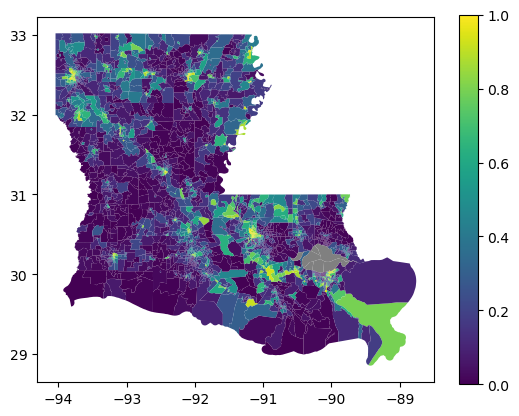

In [26]:
# Plot the black population percentage by precincts
la_data_gdf['b_frac'] = pd.to_numeric(la_data_gdf['P1_004N'])/pd.to_numeric(la_data_gdf['P1_001N'])
la_data_gdf.plot(column = 'b_frac', missing_kwds = {"color":"grey"}, legend=True)


<Axes: >

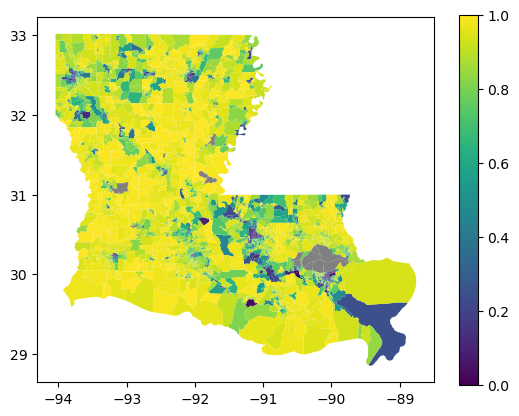

In [29]:
# Plot the senate republican votes by precincts
la_data_gdf['senate_r_perc'] = pd.to_numeric(la_data_gdf['G22USSRKEN'])/pd.to_numeric(la_data_gdf["G22USSDCHA"] + la_data_gdf["G22USSRKEN"])
la_data_gdf.plot(column = 'senate_r_perc', missing_kwds = {"color":"grey"}, legend=True)